# Convolutional Neural Network

In [5]:
# Image dimensions
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

### Importing the libraries

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [7]:
tf.__version__

'2.9.1'

## Data Preprocessing

### Preprocessing the Training set

In [8]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

training_set = train_datagen.flow_from_directory('input/Training',
                                                 target_size = IMG_SIZE,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')
labels =training_set.class_indices
print(labels)


Found 5712 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


### Preprocessing the Test set

In [9]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('input/Testing',
                                            target_size = IMG_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

Found 1311 images belonging to 4 classes.


## Building the CNN

### Loading the pretrained DenseNet121 model

In [10]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

### Adding custom layers for multiclass classification

In [11]:

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a vector
x = Dense(512, activation="relu")(x)  # Fully connected layer
x = Dense(256, activation="relu")(x)  # Additional fully connected layer
x = Dropout(0.2)(x) # Dropout layer
x = Dense(4, activation="softmax")(x)  # Output layer (4 classes)

### Creating a model

In [12]:
model = Model(inputs=base_model.input, outputs=x)

## Training the CNN

### Compiling the CNN

In [13]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block1_0_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 128)  8192        ['conv2_block1_0_relu[0][0]']    
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block1_1_bn[0][0]']      
 n)       

### Training the CNN on the Training set and evaluating it on the Test set

In [14]:
history = model.fit(x = training_set, validation_data = test_set, epochs = 10)


Epoch 1/10
179/179 [==============================] - 476s 3s/step - loss: 0.6667 - accuracy: 0.7444 - val_loss: 0.5293 - val_accuracy: 0.7933
Epoch 2/10
179/179 [==============================] - 444s 2s/step - loss: 0.4009 - accuracy: 0.8557 - val_loss: 0.4149 - val_accuracy: 0.8459
Epoch 3/10
179/179 [==============================] - 437s 2s/step - loss: 0.3432 - accuracy: 0.8782 - val_loss: 0.3668 - val_accuracy: 0.8589
Epoch 4/10
179/179 [==============================] - 431s 2s/step - loss: 0.3141 - accuracy: 0.8883 - val_loss: 0.3390 - val_accuracy: 0.8719
Epoch 5/10
179/179 [==============================] - 461s 3s/step - loss: 0.2926 - accuracy: 0.8950 - val_loss: 0.3273 - val_accuracy: 0.8711
Epoch 6/10
179/179 [==============================] - 448s 2s/step - loss: 0.2768 - accuracy: 0.9030 - val_loss: 0.3443 - val_accuracy: 0.8589
Epoch 7/10
179/179 [==============================] - 439s 2s/step - loss: 0.2541 - accuracy: 0.9072 - val_loss: 0.3549 - val_accuracy: 0.8574

### Save the model as hdf5 file

In [15]:
model.save("densenet_brain_tumor_detection_model.h5")

## Making a single prediction for each of 4 classes

In [16]:
import numpy as np
from keras import utils
test_image = utils.load_img('input/Testing/notumor/Te-no_0018.jpg', target_size = IMG_SIZE)
test_image = utils.img_to_array(test_image) /255.0
test_image = np.expand_dims(test_image, axis = 0) # Convert single image to a batch.
predicted_indice_arr = model.predict(test_image)
print(predicted_indice_arr)
prediction = np.argmax(predicted_indice_arr, axis=1)

print(labels)
final_prediction = [key for key, val in labels.items() if val == prediction[0]]
print(final_prediction)


1/1 [==============================] - 4s 4s/step
[[0.01015251 0.00240795 0.9860037  0.00143591]]
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
['notumor']


In [17]:
test_image = utils.load_img('input/Testing/pituitary/Te-pi_0018.jpg', target_size = IMG_SIZE)
test_image = utils.img_to_array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis = 0) # Convert single image to a batch.
predicted_indice_arr = model.predict(test_image)
print(predicted_indice_arr)
prediction = np.argmax(predicted_indice_arr, axis=1)

print(labels)
final_prediction = [key for key, val in labels.items() if val == prediction[0]]
print(final_prediction)


1/1 [==============================] - 0s 234ms/step
[[2.5431588e-04 2.3378089e-02 4.1625365e-03 9.7220504e-01]]
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
['pituitary']


In [18]:
test_image = utils.load_img('input/Testing/glioma/Te-gl_0018.jpg', target_size = IMG_SIZE)
test_image = utils.img_to_array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis = 0) # Convert single image to a batch.
predicted_indice_arr = model.predict(test_image)
print(predicted_indice_arr)
prediction = np.argmax(predicted_indice_arr, axis=1)

print(labels)
final_prediction = [key for key, val in labels.items() if val == prediction[0]]
print(final_prediction)


1/1 [==============================] - 0s 191ms/step
[[9.9566180e-01 2.3146793e-03 2.0012041e-03 2.2417893e-05]]
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
['glioma']


In [19]:
test_image = utils.load_img('input/Testing/meningioma/Te-me_0045.jpg', target_size = IMG_SIZE)
test_image = utils.img_to_array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis = 0) # Convert single image to a batch.
predicted_indice_arr = model.predict(test_image)
print(predicted_indice_arr)
prediction = np.argmax(predicted_indice_arr, axis=1)

print(labels)
final_prediction = [key for key, val in labels.items() if val == prediction[0]]
print(final_prediction)


1/1 [==============================] - 0s 187ms/step
[[0.004655   0.9630391  0.00681093 0.02549493]]
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
['meningioma']


## Visualize model performance

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [0.6667368412017822, 0.4008985757827759, 0.343198299407959, 0.3140918016433716, 0.2926478087902069, 0.2767520844936371, 0.2540504038333893, 0.2433941662311554, 0.23683619499206543, 0.2282284051179886], 'accuracy': [0.744397759437561, 0.8557422757148743, 0.8781512379646301, 0.8883053064346313, 0.894957959651947, 0.9030112028121948, 0.9072129130363464, 0.911939799785614, 0.9150910377502441, 0.9150910377502441], 'val_loss': [0.529276967048645, 0.4149147570133209, 0.3668212294578552, 0.33897075057029724, 0.32726332545280457, 0.3442803919315338, 0.35491734743118286, 0.27889958024024963, 0.30826354026794434, 0.24978837370872498], 'val_accuracy': [0.7932875752449036, 0.845919132232666, 0.8588863611221313, 0.8718535304069519, 0.8710907697677612, 0.8588863611221313, 0.8573607802391052, 0.893211305141449, 0.8726163506507874, 0.9023646116256714]}


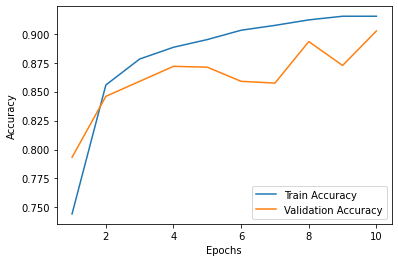

In [20]:
print(history.history.keys())
print(history.history)
epochs = range(1, len(history.history["accuracy"]) + 1)
plt.plot(epochs,  history.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

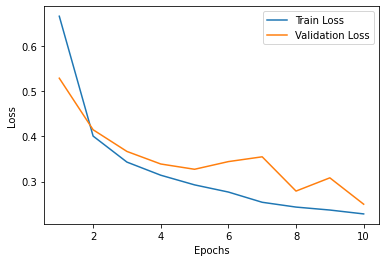

In [21]:
epochs = range(1, len(history.history["loss"]) + 1)
plt.plot(epochs,  history.history["loss"], label="Train Loss")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Fine tuning the model

In [22]:
# Unfreeze last few layers of base_model
for layer in base_model.layers[-20:]:  
    layer.trainable = True

# Compiling the model again 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Training again with unfrozen layers
history_fine_tuned = model.fit(
    training_set,
    validation_data = test_set,
    epochs=5
)


Epoch 1/5
179/179 [==============================] - 498s 3s/step - loss: 0.2997 - accuracy: 0.8913 - val_loss: 0.2857 - val_accuracy: 0.8909
Epoch 2/5
179/179 [==============================] - 506s 3s/step - loss: 0.2205 - accuracy: 0.9226 - val_loss: 0.2456 - val_accuracy: 0.9069
Epoch 3/5
179/179 [==============================] - 476s 3s/step - loss: 0.1978 - accuracy: 0.9284 - val_loss: 0.1956 - val_accuracy: 0.9252
Epoch 4/5
179/179 [==============================] - 483s 3s/step - loss: 0.1725 - accuracy: 0.9371 - val_loss: 0.1614 - val_accuracy: 0.9359
Epoch 5/5
179/179 [==============================] - 614s 3s/step - loss: 0.1497 - accuracy: 0.9463 - val_loss: 0.1796 - val_accuracy: 0.9298


In [23]:
model.save("fine_tuned_model.h5")

## Visualize model performance

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [0.29965710639953613, 0.22051289677619934, 0.19781817495822906, 0.17251577973365784, 0.14973723888397217], 'accuracy': [0.8912814855575562, 0.9226190447807312, 0.9283963441848755, 0.9371498823165894, 0.9462534785270691], 'val_loss': [0.285672128200531, 0.2456497848033905, 0.19562889635562897, 0.1614113748073578, 0.1795833557844162], 'val_accuracy': [0.8909229636192322, 0.906941294670105, 0.9252479076385498, 0.9359267950057983, 0.9298245906829834]}


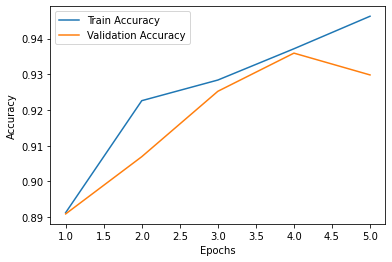

In [26]:
print(history_fine_tuned.history.keys())
print(history_fine_tuned.history)
epochs = range(1, len(history_fine_tuned.history["accuracy"]) + 1)
plt.plot(epochs,  history_fine_tuned.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history_fine_tuned.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

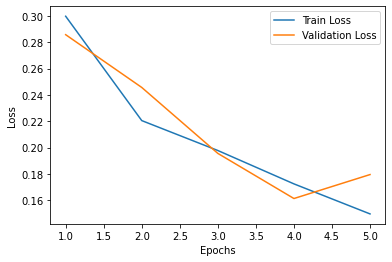

In [27]:
epochs = range(1, len(history_fine_tuned.history["loss"]) + 1)
plt.plot(epochs,  history_fine_tuned.history["loss"], label="Train Loss")
plt.plot(epochs, history_fine_tuned.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()